In [1]:
!git clone https://github.com/PaulCouairon/DiffCut.git
%cd DiffCut

fatal: destination path 'DiffCut' already exists and is not an empty directory.
/content/DiffCut


In [2]:
!pip install -r https://raw.githubusercontent.com/PaulCouairon/DiffCut/main/requirements.txt
!pip install 'git+https://github.com/facebookresearch/detectron2.git'


  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-9lwuqhw3
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-9lwuqhw3
  Resolved https://github.com/facebookresearch/detectron2.git to commit 400a49c1ec11a18dd25aea3910507bc3bcd15794
  Preparing metadata (setup.py) ... done


In [3]:
# Imports
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from google.colab import files
from tools.ldm import LdmExtractor
from diffcut.recursive_normalized_cut import DiffCut
from tools.pamr import PAMR
from scipy.ndimage import median_filter

In [4]:
# Mask refinement function
def mask_refinement(labels, image):
    masks = torch.cat([1. * (labels == label) for label in torch.unique(labels)], dim=1)
    labels_refined = PAMR(num_iter=30, dilations=[1,2,4,8,12,24,32,64])(image, masks)
    labels_refined = 1. * torch.argmax(labels_refined, dim=1)
    labels_refined = median_filter(labels_refined.cpu().numpy(), 3).astype(int)
    return labels_refined

In [5]:
# Upload custom image
uploaded = files.upload()  # Prompt user to upload
img_path = next(iter(uploaded.keys()))

Saving Dalle-Image2.jpg to Dalle-Image2.jpg


In [6]:
# Load and prepare image
pil_img = Image.open(img_path).convert('RGB')
image = T.ToTensor()(pil_img).unsqueeze(0).to("cuda")
_, _, h, w = image.shape

In [7]:
# Initialize extractor and DiffCut
extractor = LdmExtractor(model_name="SSD-1B")
img_size = 1024
t = 50

Loading SD model


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.77k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/602 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/5.33G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

SD model loaded


In [8]:
# Extract diffusion features
features = extractor(image, step=t, img_size=img_size)

# Generate masks
tau, alpha = 0.5, 10
raw_masks = DiffCut().generate_masks(features, tau=tau, mask_size=(h, w),
                                     alpha=alpha, img_size=img_size)
masks = torch.Tensor(raw_masks).to("cuda")

# Refine masks
image_resized = F.interpolate(image, size=(img_size, img_size), mode='bilinear')
new_mask = mask_refinement(masks, image_resized)[0]

# Prepare colormap
colors = sns.hls_palette(len(np.unique(new_mask)), h=0.9)
cmap = ListedColormap(colors)

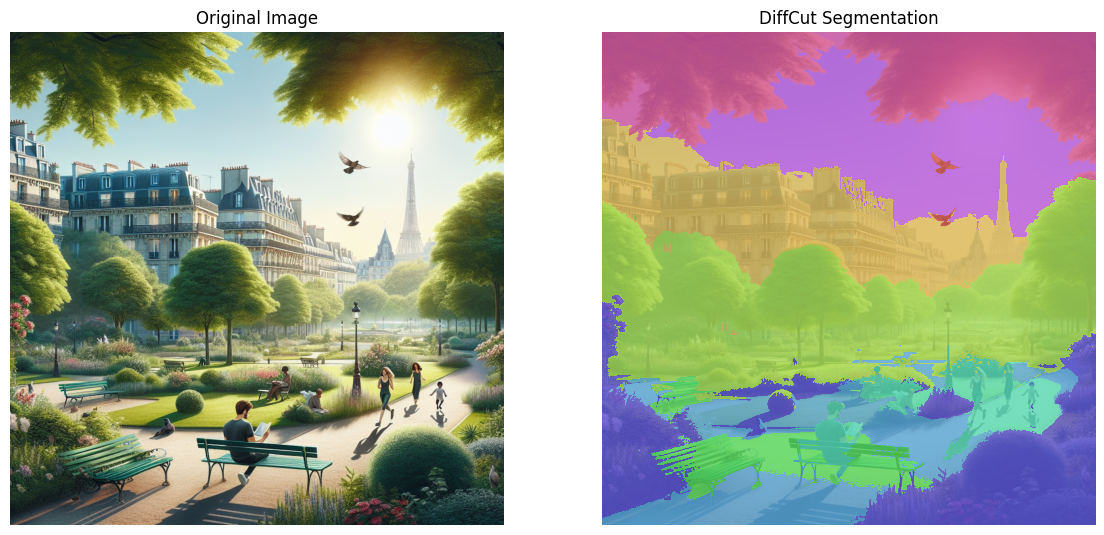

In [9]:
# Display original vs segmented side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].imshow(pil_img)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(pil_img.resize((img_size, img_size)))
axes[1].imshow(new_mask, cmap=cmap, alpha=0.8, interpolation='nearest')
axes[1].set_title("DiffCut Segmentation")
axes[1].axis("off")

plt.show()